In [1]:
import sys

# appending a path
sys.path.append('/home/pkaczyns/Code/cell-track-analysis/')
from src.cell_track_analysis.live_image_utils import extract_well, collect_nuclei_data

In [2]:
import os
import re
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

Plan: 
- Get at least unfiltered 29-10, 06-06, 15-05 and 20-05. 
- Look for the fixed images corresponding to this
- Get the method of quantifyng immunostaining

In [3]:

def get_celltype_color(celltype_str):
    if 'WT' in celltype_str:
        return 'black'
    elif 'IFNGR KO' in celltype_str:
        return 'red'
    elif 'IFNAR KO' in celltype_str:
        return 'blue'
    elif 'IFNLR KO' in celltype_str:
        return 'yellow'
    elif 'DKO' in celltype_str:
        return 'green'
    else:
        return 'gray'

def get_virus_linestyle(virus_str):
    if 'IAV' in virus_str:
        return '--'
    elif 'RSV' in virus_str:
        return '-.'
    else:
        return '-'

def is_nk(celltype_str):
    return 'NK' in celltype_str

In [4]:
model = xgb.XGBClassifier(objective='binary:logistic')  # init model
model.load_model('/home/pkaczyns/Documents/pyroptosis-annotation/object_detection/XGBoost1_.model')

In [6]:
path = "/mnt/data/2025-06-04-zkorwek-3"#/mnt/data/2024-10-29-zkorwek/Live" #
tracks = extract_well(path, None)
h2b = collect_nuclei_data(path)

/mnt/data/2025-06-04-zkorwek-3
Cleaning data
Predicting
merging


/tmp/ipykernel_1453477/798162808.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nums = nuc_df.reindex(full_index, method='ffill').fillna(method='ffill').to_numpy()


NameError: name 'ax_filtered' is not defined

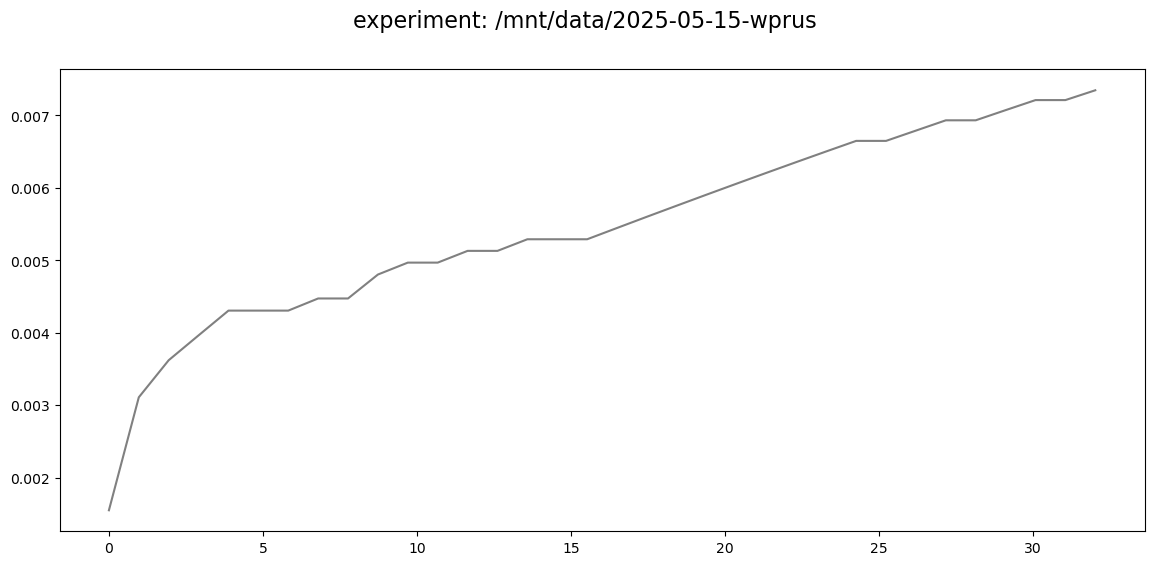

In [7]:
# TODO: wczytać czas
def rename(x):
    if 'IAV' in x:
        return 'IAV'
    elif 'RSV' in x:
        return 'RSV'
    else:
        return 'mock'
    
summary_frames = []

wells = sorted(tracks['well'].unique())
times = int(tracks['beginning'].max()) + 1
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)
fig.suptitle(f'experiment: {tracks["experiment"].iloc[0]}', fontsize=16)

# LEFT: all tracks
ax_all = axes#[0]
#ax_filtered = axes[1]
for well, group in tracks[tracks.length>5].sort_values(['CellType2', 'CellType1', 'Virus']).groupby('well'):
    virus = group['Virus'].iloc[0]
    celltype1 = group['CellType1'].iloc[0]
    celltype2 = group['CellType2'].iloc[0]

    color = get_celltype_color(celltype1)
    linestyle = get_virus_linestyle(virus)
    linewidth = 2.5 if is_nk(celltype2) else 1.5

    label = f'Well {well} | {virus} | {celltype2} | {celltype1}'
    full_index = pd.RangeIndex(times)

    # Get and prepare the partial nuclei data
    nuc_df = h2b[h2b['well'] == well] \
                .sort_values('time_point_index') \
                .drop_duplicates('time_point_index') \
                .set_index('time_point_index')['nuclei_number']

    # Reindex and forward-fill missing time points
    nums = nuc_df.reindex(full_index, method='ffill').fillna(method='ffill').to_numpy()
    H, ts = np.histogram(group['beginning'], bins=times)
    cumsum_H = np.cumsum(H / nums)
    ax_all.plot(ts[:-1], cumsum_H,
                label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    
    Hf, tsf = np.histogram(group[group['label'] == 1]['beginning'], bins=times)
    cumsum_Hf = np.cumsum(Hf / nums)
    ax_filtered.plot(tsf[:-1], cumsum_Hf,
                        label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    
    summary_frames.append({'Well': well, 'CellType2': celltype2, 'CellType1':celltype1, 'Virus': virus, 'experiment': tracks["experiment"].iloc[0], 'Cumulated unnormalized': cumsum_H[-1], 'Cumulated normalized': cumsum_Hf[-1]})

    ax_all.set_title('Cumulative unfiltered death beginnings')
    ax_all.set_xlabel('Time Point Index')
    ax_all.set_ylabel('CUmulative number of tracks')
    ax_all.legend(fontsize=8)
    
    ax_filtered.set_title('Cumulative filtered death beginnings')
    ax_filtered.set_xlabel('Time Point Index')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()
    filename = tracks["experiment"].iloc[0].split('/')[2]
plt.show()#savefig(f"./Figures/{filename}_death_cumulative.png")

/tmp/ipykernel_1453477/2268235398.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nums = nuc_df.reindex(full_index, method='ffill').fillna(method='ffill').to_numpy()


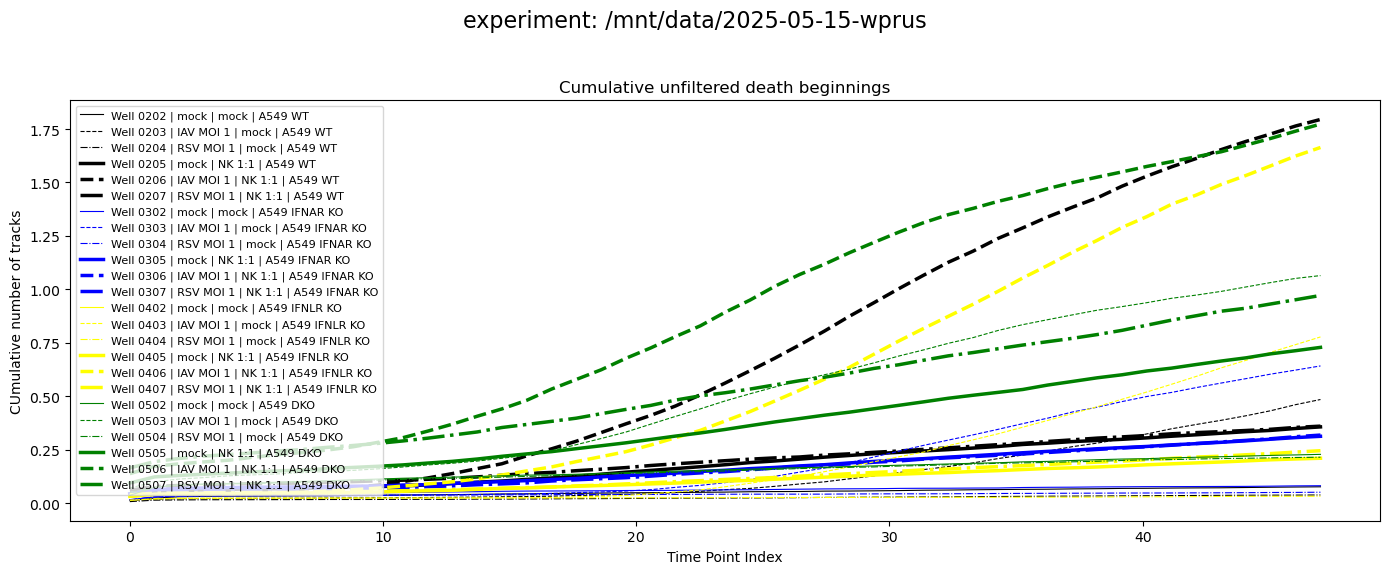

In [30]:

    
summary_frames = []

wells = sorted(tracks['well'].unique())
times = int(tracks['beginning'].max()) + 1
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)
fig.suptitle(f'experiment: {tracks["experiment"].iloc[0]}', fontsize=16)

# LEFT: all tracks
ax_all = axes#[0]
#ax_filtered = axes[1]
for well, group in tracks[tracks.length>5].sort_values(['CellType2', 'CellType1', 'Virus']).groupby('well'):
    virus = group['Virus'].iloc[0]
    celltype1 = group['CellType1'].iloc[0]
    celltype2 = group['CellType2'].iloc[0]

    color = get_celltype_color(celltype1)
    linestyle = get_virus_linestyle(virus)
    linewidth = 2.5 if is_nk(celltype2) else 0.8

    label = f'Well {well} | {virus} | {celltype2} | {celltype1}'
    full_index = pd.RangeIndex(times)

    # Get and prepare the partial nuclei data
    nuc_df = h2b[h2b['well'] == well] \
                .sort_values('time_point_index') \
                .drop_duplicates('time_point_index') \
                .set_index('time_point_index')['nuclei_number']

    # Reindex and forward-fill missing time points
    nums = nuc_df.reindex(full_index, method='ffill').fillna(method='ffill').to_numpy()
    H, ts = np.histogram(group['beginning'], bins=times)
    cumsum_H = np.cumsum(H / nums)
    ax_all.plot(ts[:-1], cumsum_H,
                label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    
    Hf, tsf = np.histogram(group[group['label'] == 1]['beginning'], bins=times)
    cumsum_Hf = np.cumsum(Hf / nums)
    #ax_filtered.plot(tsf[:-1], cumsum_Hf,
    #                    label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    
    summary_frames.append({'Well': well, 'CellType2': celltype2, 'CellType1':celltype1, 'Virus': virus, 'experiment': tracks["experiment"].iloc[0], 'Cumulated unnormalized': cumsum_H[-1], 'Cumulated normalized': cumsum_Hf[-1]})

    ax_all.set_title('Cumulative unfiltered death beginnings')
    ax_all.set_xlabel('Time Point Index')
    ax_all.set_ylabel('CUmulative number of tracks')
    ax_all.legend(fontsize=8)
    
    #ax_filtered.set_title('Cumulative filtered death beginnings')
    #ax_filtered.set_xlabel('Time Point Index')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.show()
    filename = tracks["experiment"].iloc[0].split('/')[2]
plt.show()#savefig(f"./Figures/{filename}_death_cumulative.png")

In [31]:
tracks.label.value_counts()

label
0    70471
1     7800
Name: count, dtype: int64

<Axes: >

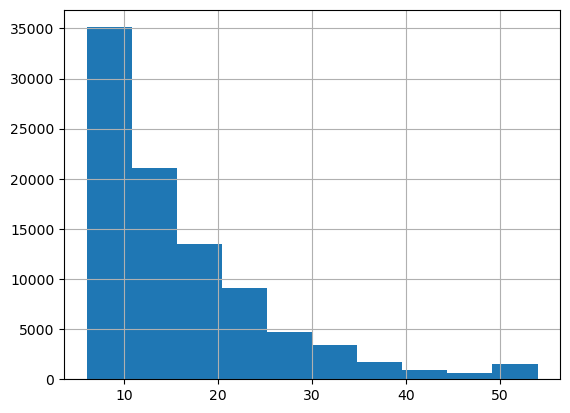

In [7]:
tracks.length.hist()

In [6]:
path = "/mnt/data/2025-05-20-wprus"#/mnt/data/2024-10-29-zkorwek/Live" #/mnt/data/2023-08-25-pkoza"#
tracks = extract_well(path, model=None, n=5)
h2b = collect_nuclei_data(path)
tracks = tracks.rename({'Virus': 'CellType1', 'CellType1': 'Virus'}, axis=1)

/mnt/data/2025-05-20-wprus
Cleaning data
Predicting
merging


In [10]:
h2b[h2b['well']=='0203']

,well,experiment,time_point_index,nuclei_number
6,0203,/mnt/data/2025-05-20-wprus,23,404
7,0203,/mnt/data/2025-05-20-wprus,25,537
8,0203,/mnt/data/2025-05-20-wprus,27,707
9,0203,/mnt/data/2025-05-20-wprus,0,8120
10,0203,/mnt/data/2025-05-20-wprus,10,8524
11,0203,/mnt/data/2025-05-20-wprus,20,8453
12,0203,/mnt/data/2025-05-20-wprus,30,7903
13,0203,/mnt/data/2025-05-20-wprus,40,7362
14,0203,/mnt/data/2025-05-20-wprus,50,6992
15,0203,/mnt/data/2025-05-20-wprus,0,93
